Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/09 22:37:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


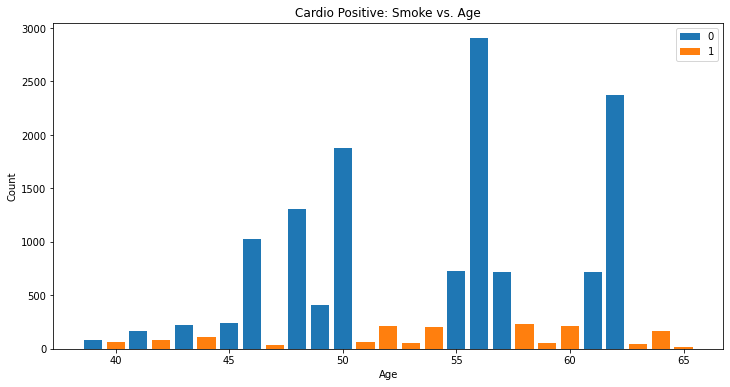

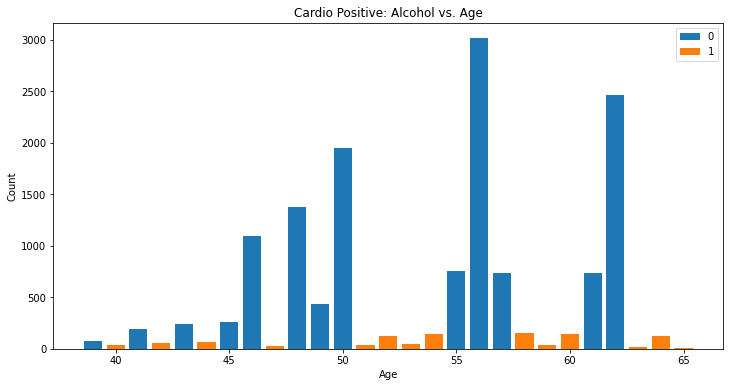

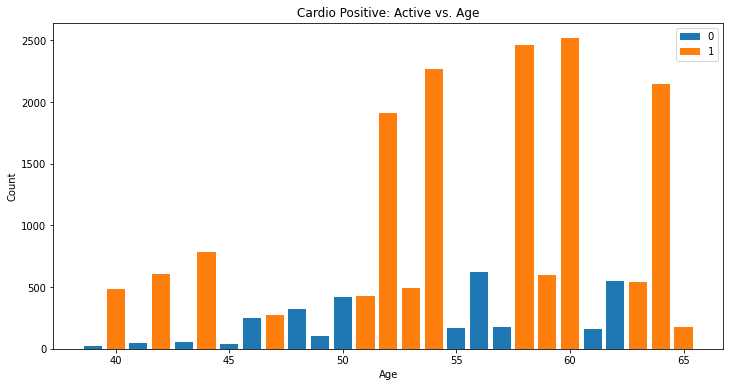

In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("VisualizationWithSpark").getOrCreate()

# Load the data
data_path = 'redu4.csv'
df = spark.read.csv(data_path, header=True, inferSchema=True)

def plot_bar(data, hue_col, title):
    age_hue_list = data.groupBy("age", hue_col).count().orderBy("age").collect()

    # Extract values from the collected data
    ages = [row['age'] for row in age_hue_list]
    hue_values = [row[hue_col] for row in age_hue_list]
    counts = [row['count'] for row in age_hue_list]

    unique_ages = sorted(list(set(ages)))
    unique_hues = list(set(hue_values))

    # Create an empty plot with defined axes
    fig, ax = plt.subplots(figsize=(12,6))

    for hue in unique_hues:
        hue_counts = []
        for age in unique_ages:
            if age in ages and hue_values[ages.index(age)] == hue:
                hue_counts.append(counts[ages.index(age)])
            else:
                hue_counts.append(0)
        ax.bar(unique_ages, hue_counts, label=str(hue))

    ax.set_xlabel('Age')
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.legend()
    plt.show()

# Filter data and call the visualization function
plot_bar(df.filter(df['cardio'] == 1), 'smoke', 'Cardio Positive: Smoke vs. Age')
plot_bar(df.filter(df['cardio'] == 1), 'alcohol', 'Cardio Positive: Alcohol vs. Age')
plot_bar(df.filter(df['cardio'] == 1), 'active', 'Cardio Positive: Active vs. Age')

In [1]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("AgeThresholdDetection").getOrCreate()

# Load data
data_path = 'redu4.csv'
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Define features and target
features = ["age"]
assembler = VectorAssembler(inputCols=features, outputCol="features")
data_assembled = assembler.transform(df)

# Initialize and fit decision tree
tree = DecisionTreeClassifier(labelCol="cardio", featuresCol="features", maxDepth=3)
model = tree.fit(data_assembled)

# Extract decision rules
tree_rules = model.toDebugString

# Extract age thresholds from the tree rules
import re
age_thresholds = [float(value) for value in re.findall(r'feature 0 <= (\d+\.\d+)', tree_rules)]

print("Age thresholds for increased risk:", age_thresholds)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/09 22:41:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Age thresholds for increased risk: [54.5]


In [2]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("AgeThresholdDetectionWithPlot").getOrCreate()

# Load data
data_path = 'redu4.csv'
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Define features and target
features = ["age"]
assembler = VectorAssembler(inputCols=features, outputCol="features")
data_assembled = assembler.transform(df)

# Initialize and fit decision tree
tree = DecisionTreeClassifier(labelCol="cardio", featuresCol="features", maxDepth=3)
model = tree.fit(data_assembled)

# Extract decision rules
tree_rules = model.toDebugString
print(tree_rules)

# NOTE: For visualization, you'll need to rely on the printed rules and either
# 1) Visualize them manually using tools or drawing applications.
# 2) Process the string in Python and generate a visualization with another library/tool.


DecisionTreeClassificationModel: uid=DecisionTreeClassifier_db2d8676d966, depth=1, numNodes=3, numClasses=2, numFeatures=1
  If (feature 0 <= 54.5)
   Predict: 0.0
  Else (feature 0 > 54.5)
   Predict: 1.0



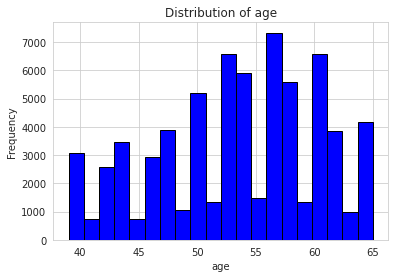

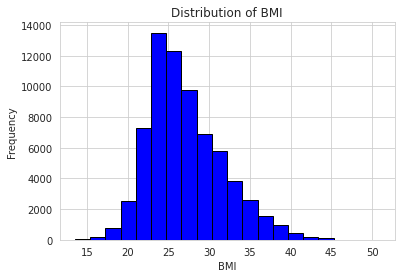

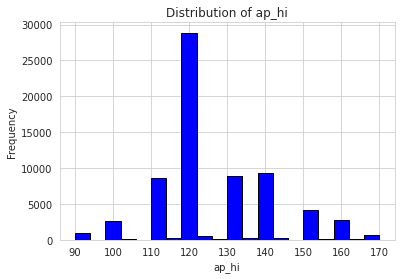

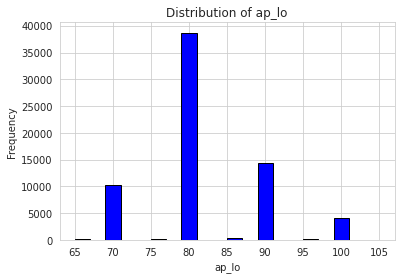

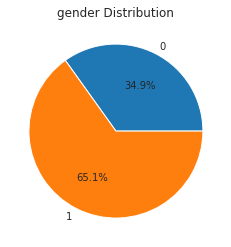

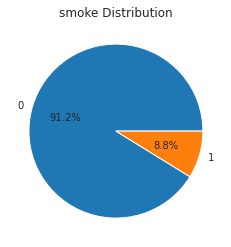

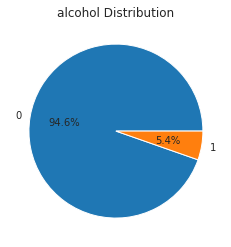

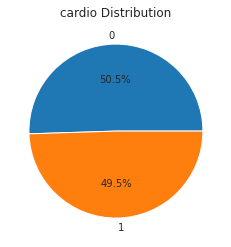

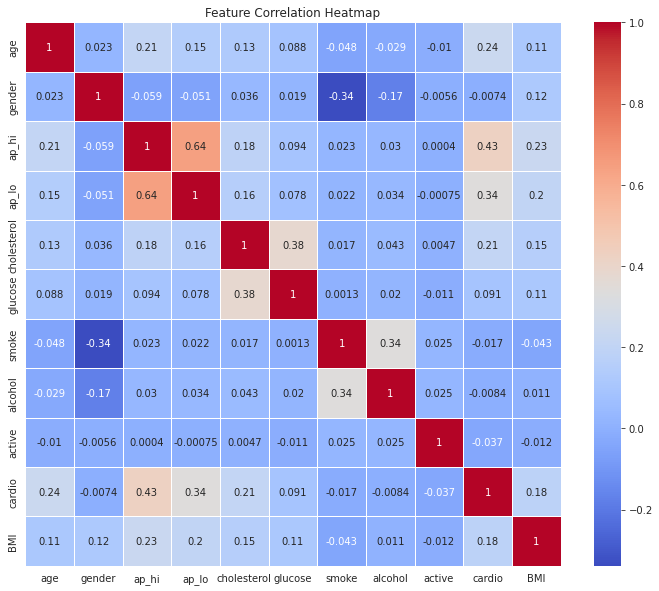

In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, collect_list, count
import matplotlib.pyplot as plt
import numpy as np

# Initialize Spark session
spark = SparkSession.builder.appName("DataVisualization").getOrCreate()

# Load data
data_path = 'redu4.csv'
df = spark.read.csv(data_path, header=True, inferSchema=True)

# 1. Data Distributions and Baseline Metrics

# Histograms for continuous variables
continuous_vars = ['age', 'BMI', 'ap_hi', 'ap_lo']

for var in continuous_vars:
    values = df.select(var).rdd.flatMap(lambda x: x).collect()
    plt.hist(values, bins=20, color='blue', edgecolor='black')
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()

# Pie Charts for categorical data
categorical_vars = ['gender', 'smoke', 'alcohol', 'cardio']

for var in categorical_vars:
    groups = df.groupBy(var).agg(count("*").alias("count")).orderBy(var).collect()
    labels = [row[var] for row in groups]
    sizes = [row["count"] for row in groups]
    
    plt.pie(sizes, labels=labels, autopct='%1.1f%%')
    plt.title(f'{var} Distribution')
    plt.show()

# 2. Correlation Heatmaps
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark session
spark = SparkSession.builder.appName("DataVisualization").getOrCreate()

# Load data
data_path = 'redu4.csv'
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Given list of columns
cols_list = ['age', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'glucose', 'smoke', 'alcohol', 'active', 'cardio', 'BMI']

# 2. Correlation Heatmaps
# We'll compute correlations for each pair of columns in the provided list.
matrix = []

for col1 in cols_list:
    row = []
    for col2 in cols_list:
        row.append(df.corr(col1, col2))
    matrix.append(row)

# Visualize the matrix using seaborn heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(matrix, annot=True, cmap='coolwarm', linewidths=0.5, xticklabels=cols_list, yticklabels=cols_list)
plt.title('Feature Correlation Heatmap')
plt.show()



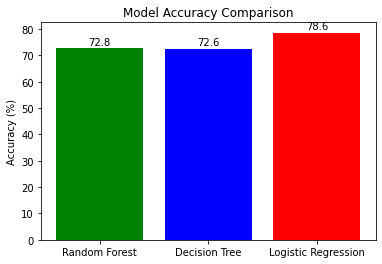

In [7]:
import matplotlib.pyplot as plt

# ... After model training ...
# 3. Model Results and Accuracy Metrics (Placeholder data)
accuracies = {'Random Forest': 72.8, 'Decision Tree': 72.6, 'Logistic Regression': 78.6}

# Plotting the bar chart
bars = plt.bar(accuracies.keys(), accuracies.values(), color=['green', 'blue', 'red'])

# Adding percentages on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.show()

In [7]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import mean, col

# Initialize Spark session
spark = SparkSession.builder \
    .appName("KMeans Visualization") \
    .getOrCreate()

# Load the data
data_path = 'redu4.csv'
data = spark.read.csv(data_path, header=True, inferSchema=True)

# Use VectorAssembler to combine features
feature_columns = data.columns  # assuming all columns are features
feature_columns.remove('cardio')  # remove non-feature columns
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_assembled = assembler.transform(data)

# Apply K-means clustering
kmeans = KMeans().setK(4).setSeed(1)
model = kmeans.fit(data_assembled)
predictions = model.transform(data_assembled)

# Obtain summary statistics for each cluster
cluster_summary = []
for i in range(4):
    cluster = predictions.filter(predictions['prediction'] == i)
    avg_cols = [mean(col).alias(col) for col in feature_columns]
    cluster_data = cluster.select(avg_cols).agg(*avg_cols).collect()[0].asDict()
    cluster_data["prediction"] = i
    cluster_summary.append(cluster_data)

# Convert results to DataFrame
df = spark.createDataFrame(cluster_summary)
df.show()



+------------------+------------------+------------------+--------------------+------------------+-----------------+-------------------+------------------+-------------------+----------+-------------------+
|               BMI|            active|               age|             alcohol|             ap_hi|            ap_lo|        cholesterol|            gender|            glucose|prediction|              smoke|
+------------------+------------------+------------------+--------------------+------------------+-----------------+-------------------+------------------+-------------------+----------+-------------------+
|28.600838978119107|0.8024906890130353|55.356436219739294| 0.06238361266294227| 135.4746275605214|87.10661080074487|0.37342877094972066|0.6432728119180633|  0.199487895716946|         0| 0.0952048417132216|
|26.369522906944322|0.7957583261897958| 52.80566403149506|0.048258564307711846|120.57888052830428|79.59691399180875|0.17465155411626504| 0.633076165984062| 0.12312283709559

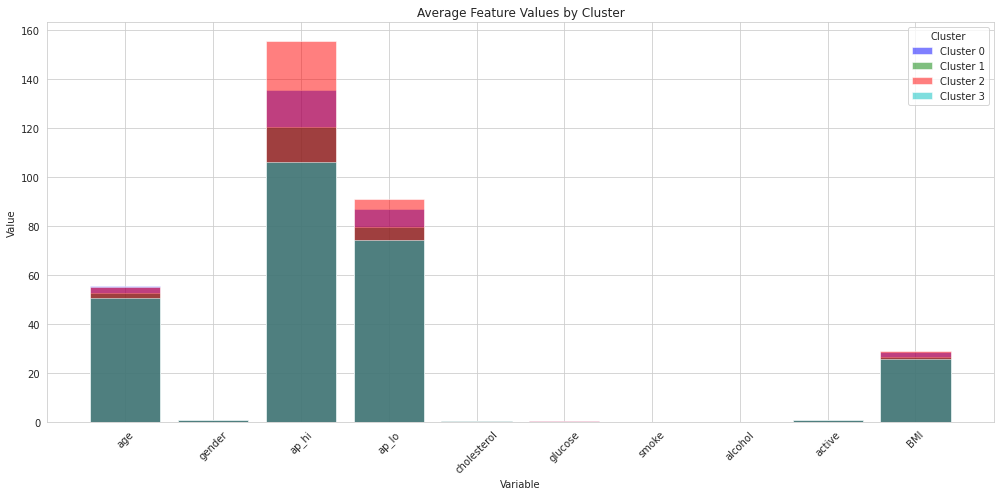

In [5]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import mean, col, collect_list, struct
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder \
    .appName("KMeans Visualization") \
    .getOrCreate()

# Load the data
data_path = 'redu4.csv'
data = spark.read.csv(data_path, header=True, inferSchema=True)

# Use VectorAssembler to combine features
feature_columns = data.columns  # assuming all columns are features
feature_columns.remove('cardio')  # remove non-feature columns
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_assembled = assembler.transform(data)

# Apply K-means clustering
kmeans = KMeans().setK(4).setSeed(1)
model = kmeans.fit(data_assembled)
predictions = model.transform(data_assembled)

# Obtain summary statistics for each cluster
cluster_data = []
for i in range(4):
    cluster = predictions.filter(col('prediction') == i)
    avg_cols = [mean(col(name)).alias(name) for name in feature_columns]
    agg_data = cluster.agg(*avg_cols).collect()
    for row in agg_data:
        row_dict = row.asDict()
        row_dict['prediction'] = i
        cluster_data.append(row_dict)

# Visualize using Matplotlib
plt.figure(figsize=(14, 7))
colors = ['b', 'g', 'r', 'c']

for i in range(4):
    values = [cluster_data[i][col_name] for col_name in feature_columns]
    plt.bar(feature_columns, values, label=f'Cluster {i}', alpha=0.5, color=colors[i])

plt.title('Average Feature Values by Cluster')
plt.ylabel('Value')
plt.xlabel('Variable')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


In [3]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Start a Spark session
spark = SparkSession.builder.appName("DecisionTreeWithSpark").getOrCreate()

# Load the dataset
data = spark.read.csv('redu4.csv', header=True, inferSchema=True)

# Data Preparation: Separating features and target
features = [col for col in data.columns if col != 'cardio']
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(data)

# Splitting the data into a training set and test set (80/20 split)
(train_data, test_data) = data.randomSplit([0.8, 0.2], seed=42)

# Initializing DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="cardio", featuresCol="features")

# Hyperparameter Tuning and Model Optimization
# Defining hyperparameters grid to search
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [3, 5, 6, 7, 10])
             .addGrid(dt.maxBins, [16, 32, 64, 128, 256])
             .addGrid(dt.impurity, ['gini', 'entropy'])
             .build())

# Set up the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")

# Setting up the CrossValidator
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Fitting the model
cvModel = crossval.fit(train_data)

# Evaluating the optimized decision tree model
predictions = cvModel.transform(test_data)
accuracy = evaluator.evaluate(predictions)

# Display results
print("Optimized Decision Tree Accuracy:", accuracy)

# Extracting and Displaying Feature Importances from the Optimized Model
best_tree = cvModel.bestModel
feature_importances_optimized = best_tree.featureImportances
importances_list = [(feature, importance) for feature, importance in zip(features, feature_importances_optimized)]
importances_sorted = sorted(importances_list, key=lambda x: x[1], reverse=True)
print("\nOptimized Decision Tree - Feature importances:")
for feat, imp in importances_sorted:
    print(f"{feat}: {imp}")

# Visualizing the Decision Tree using Spark's built-in method
print("\nDecision Tree Structure:")
print(best_tree.toDebugString)

Optimized Decision Tree Accuracy: 0.7266844035377867

Optimized Decision Tree - Feature importances:
ap_hi: 0.7585533352756992
age: 0.14261044180180812
cholesterol: 0.05621707500109271
ap_lo: 0.022746910881459182
BMI: 0.013025391333292818
active: 0.0033291826922965196
glucose: 0.001760744191214275
smoke: 0.0014734435099613525
alcohol: 0.0001421001569884401
gender: 0.00014137515618747886

Decision Tree Structure:
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ce7123940cdf, depth=7, numNodes=153, numClasses=2, numFeatures=10
  If (feature 2 <= 129.0)
   If (feature 0 <= 54.5)
    If (feature 4 <= 0.5)
     If (feature 0 <= 45.5)
      If (feature 3 <= 90.5)
       Predict: 0.0
      Else (feature 3 > 90.5)
       If (feature 6 <= 0.5)
        If (feature 9 <= 35.8485)
         Predict: 1.0
        Else (feature 9 > 35.8485)
         Predict: 0.0
       Else (feature 6 > 0.5)
        Predict: 0.0
     Else (feature 0 > 45.5)
      If (feature 3 <= 95.5)
       Predict: 0.0
  

In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Start a Spark session
spark = SparkSession.builder.appName("LogisticRegressionWithSpark").getOrCreate()

# Load the dataset
data_path = 'redu4.csv'
data = spark.read.csv(data_path, header=True, inferSchema=True)

# Define features and target
features = ['age', 'ap_hi', 'ap_lo', 'cholesterol', 'glucose', 'active', 'gender', 'BMI', 'smoke']
target = 'cardio'

# Vectorize the features
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(data)

# Split data
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

# Initial model training
lr = LogisticRegression(labelCol="cardio", maxIter=1000)
model = lr.fit(train_data)

# Evaluate initial model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="cardio", metricName="areaUnderROC")
initial_accuracy = evaluator.evaluate(model.transform(test_data))
print(f"Initial Accuracy with Logistic Regression: {initial_accuracy:.2f}")

# Feature evaluation: Use coefficients as an indicator of feature importance
coefficients = model.coefficients.toArray()
features_importance = [(feature, abs(coef)) for feature, coef in zip(features, coefficients)]
threshold = 0.05
features_to_keep = [feature for feature, importance in features_importance if importance >= threshold]

# Retrain model with refined features
assembler_refined = VectorAssembler(inputCols=features_to_keep, outputCol="features_refined")
train_data_refined = assembler_refined.transform(train_data)
test_data_refined = assembler_refined.transform(test_data)

model_refined = lr.fit(train_data_refined)
refined_accuracy = evaluator.evaluate(model_refined.transform(test_data_refined))
print(f"Refined Accuracy with Logistic Regression: {refined_accuracy:.2f}")

23/10/10 04:57:10 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/10 04:57:10 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Initial Accuracy with Logistic Regression: 0.79


Refined Accuracy with Logistic Regression: 0.79


In [7]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Start a Spark session
spark = SparkSession.builder.appName("EnsembleWithSpark").getOrCreate()

# Load the dataset
data_path = 'redu4.csv'
data = spark.read.csv(data_path, header=True, inferSchema=True)

# Define features and target
features = ['age', 'ap_hi', 'ap_lo', 'cholesterol', 'glucose', 'active', 'gender', 'BMI', 'smoke']
target = 'cardio'

# Vectorize the features
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(data)

# Split data
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

# Evaluator for classification accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")

# RandomForest Classifier
rf = RandomForestClassifier(labelCol="cardio", maxDepth=10, minInstancesPerNode=1, minInfoGain=0.0, numTrees=100, seed=42)
rf_model = rf.fit(train_data)
initial_accuracy_rf = evaluator.evaluate(rf_model.transform(test_data))
print(f"Initial Accuracy with Random Forest: {initial_accuracy_rf:.2f}")

# Use feature importances for refinement in RandomForest
importances_rf = rf_model.featureImportances.toArray()
features_to_keep_rf = [feature for feature, importance in zip(features, importances_rf) if importance >= threshold]
assembler_refined_rf = VectorAssembler(inputCols=features_to_keep_rf, outputCol="features_refined_rf")
train_data_refined_rf = assembler_refined_rf.transform(train_data)
test_data_refined_rf = assembler_refined_rf.transform(test_data)
rf_model_refined = rf.fit(train_data_refined_rf)
refined_accuracy_rf = evaluator.evaluate(rf_model_refined.transform(test_data_refined_rf))
print(f"Refined Accuracy with Random Forest: {refined_accuracy_rf:.2f}")

# DecisionTree Classifier
dt = DecisionTreeClassifier(labelCol="cardio", maxDepth=7, minInstancesPerNode=4, seed=42)
dt_model = dt.fit(train_data)
initial_accuracy_dt = evaluator.evaluate(dt_model.transform(test_data))
print(f"Initial Accuracy with Decision Tree: {initial_accuracy_dt:.2f}")

# Use feature importances for refinement in DecisionTree
importances_dt = dt_model.featureImportances.toArray()
features_to_keep_dt = [feature for feature, importance in zip(features, importances_dt) if importance >= threshold]
assembler_refined_dt = VectorAssembler(inputCols=features_to_keep_dt, outputCol="features_refined_dt")
train_data_refined_dt = assembler_refined_dt.transform(train_data)
test_data_refined_dt = assembler_refined_dt.transform(test_data)
dt_model_refined = dt.fit(train_data_refined_dt)
refined_accuracy_dt = evaluator.evaluate(dt_model_refined.transform(test_data_refined_dt))
print(f"Refined Accuracy with Decision Tree: {refined_accuracy_dt:.2f}")


23/10/10 05:03:48 WARN DAGScheduler: Broadcasting large task binary with size 1709.3 KiB
23/10/10 05:03:52 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/10/10 05:03:57 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
23/10/10 05:04:01 WARN DAGScheduler: Broadcasting large task binary with size 1439.8 KiB
23/10/10 05:04:03 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
23/10/10 05:04:08 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/10/10 05:04:10 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


Initial Accuracy with Random Forest: 0.73


23/10/10 05:04:27 WARN DAGScheduler: Broadcasting large task binary with size 1709.3 KiB
23/10/10 05:04:31 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/10/10 05:04:37 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
23/10/10 05:04:40 WARN DAGScheduler: Broadcasting large task binary with size 1439.8 KiB
23/10/10 05:04:42 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
23/10/10 05:04:47 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/10/10 05:04:49 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


Refined Accuracy with Random Forest: 0.73


Initial Accuracy with Decision Tree: 0.73
Refined Accuracy with Decision Tree: 0.73


In [9]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Start a Spark session
spark = SparkSession.builder.appName("LogisticRegressionWithSpark").getOrCreate()

# Load the dataset
data_path = 'redu4.csv'
data = spark.read.csv(data_path, header=True, inferSchema=True)

# Define features and target
features = ['age', 'ap_hi', 'ap_lo', 'cholesterol', 'glucose', 'active', 'gender', 'BMI', 'smoke']
target = 'cardio'

# Vectorize the features
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(data)

# Split data
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Initial model training
lr = LogisticRegression(labelCol="cardio", maxIter=1000)
model = lr.fit(train_data)

# Evaluate initial model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="cardio", metricName="areaUnderROC")
initial_accuracy = evaluator.evaluate(model.transform(test_data))
print(f"Initial Accuracy with Logistic Regression: {initial_accuracy:.2f}")

# Feature evaluation: Use coefficients as an indicator of feature importance
coefficients = model.coefficients.toArray()
features_importance = [(feature, abs(coef)) for feature, coef in zip(features, coefficients)]
threshold = 0.05
features_to_keep = [feature for feature, importance in features_importance if importance >= threshold]

# Retrain model with refined features
assembler_refined = VectorAssembler(inputCols=features_to_keep, outputCol="features_refined")
train_data_refined = assembler_refined.transform(train_data)
test_data_refined = assembler_refined.transform(test_data)

model_refined = lr.fit(train_data_refined)
refined_accuracy = evaluator.evaluate(model_refined.transform(test_data_refined))
print(f"Refined Accuracy with Logistic Regression: {refined_accuracy:.2f}")

Initial Accuracy with Logistic Regression: 0.79
Refined Accuracy with Logistic Regression: 0.79


In [11]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Start a Spark session
spark = SparkSession.builder.appName("EnsembleWithSpark").getOrCreate()

# Load the dataset
data_path = 'redu4.csv'
data = spark.read.csv(data_path, header=True, inferSchema=True)

# Define features and target
features = ['age', 'ap_hi', 'ap_lo', 'cholesterol', 'glucose', 'active', 'gender', 'BMI', 'smoke']
target = 'cardio'

# Vectorize the features
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(data)

# Split data
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Evaluator for classification accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")

# RandomForest Classifier
rf = RandomForestClassifier(labelCol="cardio", maxDepth=10, minInstancesPerNode=1, minInfoGain=0.0, numTrees=100, seed=42)
rf_model = rf.fit(train_data)
initial_accuracy_rf = evaluator.evaluate(rf_model.transform(test_data))
print(f"Initial Accuracy with Random Forest: {initial_accuracy_rf:.2f}")

# Use feature importances for refinement in RandomForest
importances_rf = rf_model.featureImportances.toArray()
features_to_keep_rf = [feature for feature, importance in zip(features, importances_rf) if importance >= threshold]
assembler_refined_rf = VectorAssembler(inputCols=features_to_keep_rf, outputCol="features_refined_rf")
train_data_refined_rf = assembler_refined_rf.transform(train_data)
test_data_refined_rf = assembler_refined_rf.transform(test_data)
rf_model_refined = rf.fit(train_data_refined_rf)
refined_accuracy_rf = evaluator.evaluate(rf_model_refined.transform(test_data_refined_rf))
print(f"Refined Accuracy with Random Forest: {refined_accuracy_rf:.2f}")

# DecisionTree Classifier
dt = DecisionTreeClassifier(labelCol="cardio", maxDepth=7, minInstancesPerNode=4, seed=42)
dt_model = dt.fit(train_data)
initial_accuracy_dt = evaluator.evaluate(dt_model.transform(test_data))
print(f"Initial Accuracy with Decision Tree: {initial_accuracy_dt:.2f}")

# Use feature importances for refinement in DecisionTree
importances_dt = dt_model.featureImportances.toArray()
features_to_keep_dt = [feature for feature, importance in zip(features, importances_dt) if importance >= threshold]
assembler_refined_dt = VectorAssembler(inputCols=features_to_keep_dt, outputCol="features_refined_dt")
train_data_refined_dt = assembler_refined_dt.transform(train_data)
test_data_refined_dt = assembler_refined_dt.transform(test_data)
dt_model_refined = dt.fit(train_data_refined_dt)
refined_accuracy_dt = evaluator.evaluate(dt_model_refined.transform(test_data_refined_dt))
print(f"Refined Accuracy with Decision Tree: {refined_accuracy_dt:.2f}")


23/10/10 05:20:58 WARN DAGScheduler: Broadcasting large task binary with size 1714.8 KiB
23/10/10 05:21:02 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/10/10 05:21:08 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
23/10/10 05:21:14 WARN DAGScheduler: Broadcasting large task binary with size 1498.1 KiB
23/10/10 05:21:16 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
23/10/10 05:21:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/10/10 05:21:24 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


Initial Accuracy with Random Forest: 0.73


23/10/10 05:21:41 WARN DAGScheduler: Broadcasting large task binary with size 1714.8 KiB
23/10/10 05:21:45 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/10/10 05:21:51 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
23/10/10 05:21:56 WARN DAGScheduler: Broadcasting large task binary with size 1498.1 KiB
23/10/10 05:21:58 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
23/10/10 05:22:04 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/10/10 05:22:06 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


Refined Accuracy with Random Forest: 0.73
Initial Accuracy with Decision Tree: 0.73
Refined Accuracy with Decision Tree: 0.73
